# **Un peu d'Exploratory Data Analysis avant toutes choses**

Ce notebook vise à explorer rapidement la base de données pour avoir une idée de sa structure, de la répartition et des éventuels déséquilibres entre les classes cibles ainsi que les caractéristiques des textes à analyser. Cela est éventuellement l'occasion de détecter des particularismes dans les messages qu'il faudra bien prendre en compte dans le preprocessing.

Les principales conclusions sont :
- Labels overlapping mais équilibrés dans l'échantillon test
- Attention à l'encodage _diacritique_ des accents qui ne correspond pas à celui "du clavier azerty" (exemple : é dans le jeu de données est égale à e (U+0065)

# 1. Packages usuels et importation de la base train

In [1]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Packages classiques
import pandas as pd

# Custom package
import func_custom as fc

# NLP
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Les messages étant longs, cela permettra de visualiser un peu plus de contenu directement depuis le notebook
pd.set_option('max_colwidth', 300)

La variable `Unnamed: 0` semble juste être un indice de ligne, on peut pour le moment ne pas le garder pour l'analyse. Gardons l'encodage par défaut de `pd.read_excel` et nous étudierons cela plus tard dans le notebook.

In [4]:
df = pd.read_excel("data/data_train.xlsx",
                    usecols = ["label", "message"])

# 2. Rapides statistiques descriptives : dataframe et `label`

In [5]:
df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    700 non-null    object
 1   message  700 non-null    object
dtypes: object(2)
memory usage: 1008.4 KB


Il n'y a _a priori_ pas de valeurs nulles dans l'échantillon, vérifions le case suivante.

In [6]:
df.isna().sum()

label      0
message    0
dtype: int64

In [7]:
df.sample(3)

,label,message
105,1,"Bonjour Je me permets de vous contacter pour vous signaler une baisse de revenus sur 0000. En effet je suis au chômage depuis le 0000 novembre 0000. En consultant mon espace personnel de prélèvement à la source, je constate que le taux est de %. Je ne comprends pas trop ce que cela signifie...."
97,8,"Bonjour, je viens de déclarer mon mariage avec mon conjoint Mr XXXXX XXXXX. J'ai le choix entre individualiser mon taux ou non. Donc soit 0000.0000% pour moi et 0000% pour lui OU 0000.0000% pour lui et 0000.0000% pour moi. Est ce qu'un choix en terme de gain d’impôts est meilleur à faire ? A ..."
371,8,"Bonjour, j'aimerais savoir comment faire pour que le prélèvement à la source du foyer soit prélevé sur mon salaire uniquement. C'est à dire que j'aimerais que ma partenaire ai un taux de 0000% et que moi subisse la totalité du prélèvement. Est ce possible ? XXXXX"


Regardons maintenant succinctement la distribution des labels

In [8]:
df["label"].value_counts()

label
8      309
1      302
1:8     89
Name: count, dtype: int64

On constate que l'échantillon est **équilibré entre les classes 1 et 8**. Il n'y a pas de déséquilibres et donc les techniques de prises en charge d'_imbalanced dataset_ ne sont pas nécessaires :
- L'accuracy ne sera pas une _si_ mauvaise métrique, même si l'on en regardera d'autres (F1, ROC-AUC, cf. `2. Models.ipnyb`)
- Upsampling, downsampling voire SMOTE pour augmentation synthétique
- Prise en compte dans les modèles directement (changement de la loss function pour pénaliser plus durement erreurs sur classe minoritaire)
- Optimisation des hyperparamètres en prenant en compte une métrique sensible aux déséquilibres de classes (F1, ROC-AUC)

# 3. Exploration des `message`

Certes partie vise i) à identifier des premiers éléments à partir de l'étude brute du texte et ii) découvrir des éléments importants qu'il faudra tenir en compte dans le preprocessing

## 3.1 Métriques simples

In [9]:
# Générateur aléatoire de messages pour première inspection visuelle
df.sample(1)["message"].values[0]

'Bonjour , mon taux de prélèvement est a ce jour, calculés sur revenus 0000 de 0000.0000 % et je suis prélevé a ce taux depuis le 0000/0000/0000 ; or, sur mes revenus 0000 mon taux est passé à 0000.0000 % ( suite a l édition de l avis de situation déclarative sur revenus 0000) ; Quand vais être remboursé du trop versé de XXXXX à ce jour et quand mon nouveau taux va t-il être appliqué sur mes pensions ? Merci pour votre réponse Cordialement XXXXX XXXXX'

In [10]:
# Quelques fonctions simples pour caractériser les messages, et comparer d'éventuelles différences entre les labels
# Les mots dans count_words sont délimités non par un .split() sur espaces mais via le tokenizer de nltk
df["len_message"] = df["message"].apply(len) 
df["count_words"] = df["message"].apply(lambda x: fc.count_words(x))

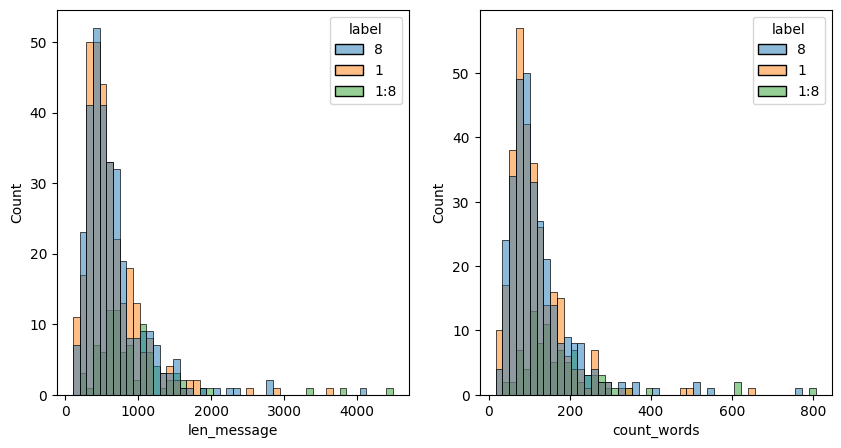

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_ = sns.histplot(data = df,
                 ax = axes[0],
                 x = "len_message",
                 hue = "label")

_ = sns.histplot(data = df,
                 ax = axes[1],
                 x = "count_words",
                 hue = "label")

Sans surprise on ne constate pas de différences notables entre les classes sur la base de ces variables explicatives simples.

## 3.2 WordCloud (quasi) brut

Réalisons un premier WordCloud simple pour observer les thématiques principales des messages

In [12]:
# Concaténer tous les textes dans cette colonne en une seule chaîne de caractères
text = ' '.join(df["message"].dropna())

# Premier jeu standard de stopwords que l'on travaillera dans le notebook suivant
stopwords_french = set(stopwords.words('french'))

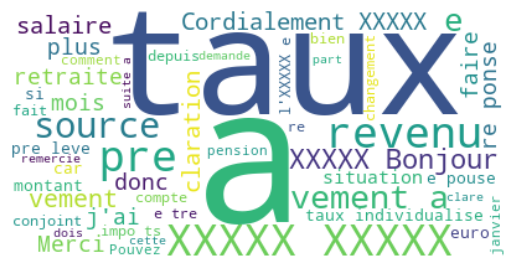

In [13]:
wordcloud = WordCloud(background_color = 'white',
                      stopwords =  stopwords_french,
                      max_words = 50).generate(text)

# Affichage du nuage de mots
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Sans surprise ce nuage de mot n'est pas très informatif. En plus des biais inhérent aux nuages de mots (mauvaise visualisation de l'information, biais vers les mots longs) on constate d'autres choses :
- Stopwork supplémentaires à prendre en compte (`XXXXX` issus de pseudonymisation)
- **Problème autour des accents qui scindent les mots** : il faudra regarder pour la normalisation des mots avec accents

Il est déjà nécessaire de rentrer un peu plus dans le preprocessing pour prendre en compte ces spécificités et pouvoir en tirer plus d'informations, ainsi qu'être exploitable en vue du machine learning.